In [1]:
import os
import pickle
import pandas as pd
import itertools as itt
import matplotlib.pyplot as plt

import networkx as nx

In [2]:
#regulons_fname = 'D:Robin/pyscenic/regulons_nuc.p'
#regulons_fname = '../../pyscenic_data/pyscenic_pipeline/regulons_nuc.p'
regulons_fname = '../../pyscenic_data/projection_neurons/regulons_nuc.p'

In [3]:
#OUT_FOLDER = 'D:Robin/pyscenic/network_analysis'
OUT_FOLDER = '../../pyscenic_data/projection_neurons/network_analysis'

In [36]:
tfs_fname = '../../pyscenic_data/pyscenic_pipeline/mm_tfs.txt'

with open(tfs_fname) as f:
    master_tfs = f.read().splitlines()

In [4]:
regulons = pickle.load(open(regulons_fname,'rb'))

In [6]:
len(regulons)

185

In [7]:
## regulons specific to projection neurons
#mt_names = ['Arid5b(+)', 'Mef2a(+)', 'Peg3(+)', 'Rcor1(+)', 'Tbx21(+)'] #125
mt_names = ['Ebf1(+)', 'Lxh1(+)', 'Lhx5(+)', 'Irf4(+)', 'Pou3f1(+)', 'Pou2f1(+)', 'Rcor1(+)', 'Rarb(+)', 'Six4(+)','Tbx21(+)'] #185

In [8]:
mt_regulons = [regulon for regulon in regulons if regulon.name in mt_names]

In [9]:
mt_tfs = [regulon.transcription_factor for regulon in regulons if regulon.name in mt_names]

# Self-regulating regulons

In [10]:
self_regulating = [regulon.name for regulon in regulons if regulon.transcription_factor in regulon.genes]

In [12]:
len(self_regulating)

108

In [13]:
#are our mt regulons self-regulating?
print([name for name in mt_names if name in self_regulating])

['Lhx5(+)', 'Irf4(+)', 'Pou2f1(+)', 'Rcor1(+)', 'Rarb(+)', 'Six4(+)']


# Regulons upstream of MT regulons

In [14]:
x = []
for regulon in mt_regulons:
    x.extend(regulon.genes)
    x.append(regulon.transcription_factor)
mt_genes = set(x)

In [15]:
len(mt_genes)

317

In [16]:
upstream_regulons = [regulon for regulon in regulons if len(mt_genes.intersection(set(regulon.genes))) != 0]

In [17]:
upstream_regulons = []
upstream_dict = {}
for regulon in regulons:
    if regulon not in mt_regulons and len(mt_genes.intersection(set(regulon.genes))) != 0:
        upstream_regulons.append(regulon)
        upstream_dict[regulon] = mt_genes.intersection(set(regulon.genes))

In [18]:
len(upstream_regulons)

101

# Anton's graph theory

## Network view on all regulons

In [79]:
#new graph
graph = nx.DiGraph()

### Add nodes

In [29]:
#add all TFs and targets as nodes
TFs = [regulon.transcription_factor for regulon in regulons]

genes_not_flat = [regulon.genes for regulon in regulons] #gives lives of tuples
genes_flattened = [item for sublist in genes_not_flat for item in sublist]
genes = list(set(genes_flattened)) #list each gene only once

graph.add_nodes_from(TFs)
graph.add_nodes_from(genes)

In [30]:
graph.number_of_nodes()

8127

In [35]:
graph.nodes['Ebf1']

{'type': 'gene', 'TF': False, 'mt': True}

In [62]:
#adding edges: should be of format (2, 3, {'weight': 3.1415})
edge_tuple_list = []
for regulon in regulons:
    for gene in regulon.gene2weight:
        #edge_tuple_list.append((regulon.transcription_factor,gene,{'weight':regulon.gene2weight[gene]}))
        edge_tuple_list.append((regulon.transcription_factor,gene,regulon.gene2weight[gene])) #because directed graph

In [66]:
graph.add_weighted_edges_from(edge_tuple_list)

In [67]:
graph.number_of_edges()

28039

In [ ]:
graph.edges(mt_tfs) #list all edges from the nodes I input

In [70]:
# Remove all nodes that do not have any in/out edges
lonely_genes = [n for n in graph if graph.degree(n) == 0]
graph.remove_nodes_from(lonely_genes)

## networkx is not made for visualization, so we export the graph to a form Cytoscape can read

In [72]:
nx.write_graphml(graph, os.path.join(OUT_FOLDER,'all_regulons.graphml'))

In [ ]:
nx.draw(graph, with_labels=True, font_weight='bold')

# Looking at only regulons upstream of MT

In [80]:
#new graph
upstream_graph = nx.DiGraph()

In [81]:
#add as nodes: TFs and genes from MT regulons, just TFs from upstream regulons
mt_TFs = [regulon.transcription_factor for regulon in mt_regulons]
upstream_TFs = [regulon.transcription_factor for regulon in upstream_regulons]

genes_not_flat = [regulon.genes for regulon in mt_regulons] #gives lives of tuples
genes_flattened = [item for sublist in genes_not_flat for item in sublist]
genes = list(set(genes_flattened)) #list each gene only once

upstream_graph.add_nodes_from(mt_TFs)
upstream_graph.add_nodes_from(genes)
upstream_graph.add_nodes_from(upstream_TFs)

#### Add node attributes

In [82]:
for node in upstream_graph.nodes:   
    if node in master_tfs:
        upstream_graph.nodes[node]['TF'] = True
    else:
        upstream_graph.nodes[node]['TF'] = False
        
    if node in mt_tfs or node in mt_genes:
        upstream_graph.nodes[node]['mt'] = True
    else:
        upstream_graph.nodes[node]['mt'] = False
        
    if upstream_graph.nodes[node]['TF'] and upstream_graph.nodes[node]['mt']:
        upstream_graph.nodes[node]['mt_TF'] = True
    else:
        upstream_graph.nodes[node]['mt_TF'] = False

In [ ]:
upstream_graph.nodes.data()

In [84]:
upstream_graph.number_of_nodes()

415

#### Add edges

In [85]:
#adding edges: should be of format (2, 3, {'weight': 3.1415})
edge_tuple_list = []

#all genes in mt_regulons
for regulon in mt_regulons:
    for gene in regulon.gene2weight:
        #edge_tuple_list.append((regulon.transcription_factor,gene,{'weight':regulon.gene2weight[gene]}))
        edge_tuple_list.append((regulon.transcription_factor,gene,regulon.gene2weight[gene])) #because directed graph
        

#only genes in upstream_dict for upstream regulons       
for regulon in upstream_regulons:
    for gene in upstream_dict[regulon]: #only certain genes
        #edge_tuple_list.append((regulon.transcription_factor,gene,{'weight':regulon.gene2weight[gene]}))
        edge_tuple_list.append((regulon.transcription_factor,gene,regulon.gene2weight[gene])) #because directed graph
        

In [86]:
len(edge_tuple_list)

884

In [87]:
upstream_graph.add_weighted_edges_from(edge_tuple_list)

In [90]:
upstream_graph.number_of_edges()

884

### Add attributes to edges

In [89]:
#this will allow me to color edges by their target
for (source, target) in upstream_graph.edges:
    if target in master_tfs:
        upstream_graph.edges[(source,target)]['TF_target'] = True
    else:
        upstream_graph.edges[(source,target)]['TF_target'] = False
        
    if target in mt_tfs or target in mt_genes:
        upstream_graph.edges[(source,target)]['mt_target'] = True
    else:
        upstream_graph.edges[(source,target)]['mt_target'] = False
        
    if upstream_graph.edges[(source,target)]['TF_target'] and upstream_graph.edges[(source,target)]['mt_target']:
        upstream_graph.edges[(source,target)]['mt_tf_target'] = True
    else:
        upstream_graph.edges[(source,target)]['mt_tf_target'] = False

In [93]:
#this will allow me to color edges by their target (have found with Cytoscape that going beyond booleans can be useful)
for (source, target) in upstream_graph.edges:
    if target in mt_tfs:
        upstream_graph.edges[(source,target)]['target'] = 'mt tf'
    elif target in master_tfs:
        upstream_graph.edges[(source,target)]['target'] = 'tf (non-mt)'
    else:
        upstream_graph.edges[(source,target)]['target'] = 'gene'


In [ ]:
upstream_graph.edges(mt_tfs) #list all edges from the nodes I input

In [ ]:
upstream_graph.edges.data()

## networkx is not made for visualization, so we export the graph to a form Cytoscape can read

In [95]:
nx.write_graphml(upstream_graph, os.path.join(OUT_FOLDER,'mt_upstream_regulons.graphml'))

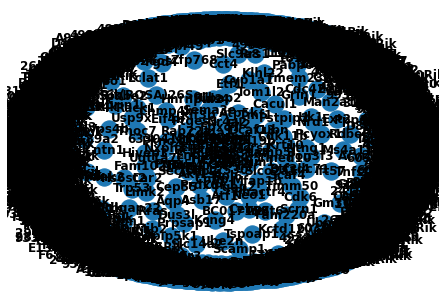

In [61]:
nx.draw(graph, with_labels=True, font_weight='bold')

## Anton's stuff (for inspiration)

In [24]:
# Function to write out regulons (TF + targets) as nodes and 
# edges of a graph/network. I then use cytoscape to visualize
# the network, but I should really transition to the python
# package 'networkx' as it removes an external software dependency.

from typing import List, Mapping, Sequence, Optional
from pyscenic.genesig import Regulon
import networkx as nx

# Export regulons as GraphML
def export_regulons(regulons: Sequence[Regulon], fname: str) -> None:
    """
    Export regulons as GraphML.
    :param regulons: The sequence of regulons to export.
    :param fname: The name of the file to create.
    """
#     all_node_names = set(tf_names)
    all_node_names = set([r.transcription_factor for r in regulons])
    
    graph = nx.DiGraph()
    for regulon in regulons:
        src_name = regulon.transcription_factor
        graph.add_node(src_name, group='transcription_factor', label=src_name)
        
        for dst_name, edge_strength in regulon.gene2weight.items():
#             graph.add_node(dst_name, group=node_type)
            if dst_name in all_node_names:
                graph.add_edge(src_name, dst_name, weight=float(edge_strength))
    
    # Remove all nodes that do not have any in/out edges
    lonely_genes = [n for n in graph if graph.degree(n) == 0]
    graph.remove_nodes_from(lonely_genes)
    
    nx.readwrite.write_graphml(graph, fname)

In [28]:
# Write cell type specific networks to file for Cytoscape
#he only does high_regulons, but I'm doing all of them
for ct, hregulons in regulons.items():
    export_regulons([r for r in regulons if r.name in set(hregulons)], 
                    # "celltype_networks/2020-02-17_nuc_regulons_ctype_{}.graphml".format(ct))
                    os.path.join(OUT_FOLDER,"celltype_networks/pyscenic_nuc_regulons_ctype_{}.graphml").format(ct))
    

AttributeError: 'list' object has no attribute 'items'

In [35]:
from operator import itemgetter

def shared_targets(regulons, tf_only=False):
    """
    Each cell type has a list of high-scoring regulons. I want to know what genes 
    they target and how often each gene is regulated.
    """
    # Dict of target genes and how often they are targeted by the top regulons of a cell type
    target_genes = {}
    
    for regulon in regulons:
        for g in regulon.gene2weight.keys():
            target_genes[g] = target_genes.get(g, 0) + 1
    
    if tf_only:
        my_tfs = set(tf_names)
        # Return a dict of counts with the corresponding tfs
        counted_genes = {}
        for g,c in target_genes.items():
            if g in my_tfs:
                counted_genes.setdefault(c, []).append(g)
        counted_genes = {c: sorted(g) for c, g in counted_genes.items()}
        
    else:
        # Return a dict of counts with the corresponding genes
        counted_genes = {}
        for g,c in target_genes.items():
            counted_genes.setdefault(c, []).append(g)
        counted_genes = {c: sorted(g) for c, g in counted_genes.items()}
    
    return counted_genes

In [41]:
# Look at top regulons per cell type and their target transcription factors.
# In other words, I only want to look at TFs that are both regulating 
# and being regulated and I ignore other genes that are regulated by TFs.

mincount = 1
for ct, hregulons in high_regulons.items():
    print("# Cell type {}".format(ct))
    aux = shared_targets([r for r in regulons if r.name in set(hregulons)], tf_only=True)
    for c, g in sorted(aux.items()):
        if c > mincount:
            print("Occurrence: {}, TFs as target: {}".format(c, g))
    print("---")

# Cell type 1
Occurrence: 2, TFs as target: ['Etv1']
---
# Cell type 2
---
# Cell type 3
Occurrence: 2, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 4
Occurrence: 2, TFs as target: ['Btbd11', 'Cbx2', 'Foxd3', 'Hes1', 'Lef1', 'Prox1', 'Tcf7l2', 'Thra', 'Zfp36l1']
Occurrence: 3, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 5
Occurrence: 2, TFs as target: ['Btbd11', 'Cbx2', 'Foxd3', 'Hes1', 'Lef1', 'Prox1', 'Tcf7l2', 'Zfp36l1']
Occurrence: 3, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 6
Occurrence: 2, TFs as target: ['Btbd11', 'Cbx2', 'Foxd3', 'Hes1', 'Lef1', 'Prox1', 'Tcf7l2', 'Zfp36l1']
Occurrence: 3, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 7
---
# Cell type 8
Occurrence: 2, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 9
Occurrence: 2, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 10
Occurrence: 2, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 11
Occurrence: 2, TFs as target: ['Lmo4', 'Nr2f2'

In [43]:
# Look at top regulons per cell type and their target transcription factors. Do these form little networks? 
mincount = 1
for ct, hregulons in high_regulons.items():
    # Collect all target regulators that are reasonably abundant
    aux = shared_targets([r for r in regulons if r.name in set(hregulons)], tf_only=True)
    # List comprehension also flattens list!
    targets_hregulons = [gname + '(+)' for c, gns in aux.items() if c > mincount for gname in gns]
    export_regulons([r for r in regulons if r.name in set(targets_hregulons)], 
                     #"targets_regulons_networks/2020-02-17_nuc_targets_ctype_{}.graphml".format(ct))
                     os.path.join(OUT_FOLDER,"targets_regulons_networks/pyscenic_nuc_regulons_ctype_{}.graphml").format(ct))